In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from PIL import ImageFilter
import cv2
import io

## Plotting helpers

These are some helper functions to plot some things later:

In [2]:

def plot_pixels_and_channels(sample_array, grayscale, dataset_info):
    """Plot RGB channels, grayscale conversion, and statistics"""
    fig, axes = plt.subplots(2, 4, figsize=(16, 8), dpi=75)
    fig.suptitle('Understanding Pixels and Channels', fontsize=16)
    
    # Original image
    axes[0, 0].imshow(sample_array)
    axes[0, 0].set_title(f'Original RGB Image\n{sample_array.shape[0]}x{sample_array.shape[1]}x3 = {sample_array.size:,} values')
    axes[0, 0].axis('off')
    
    # Individual RGB channels
    for i, (channel, color) in enumerate(zip(['Red', 'Green', 'Blue'], ['Reds', 'Greens', 'Blues'])):
        axes[0, i+1].imshow(sample_array[:,:,i], cmap=color)
        axes[0, i+1].set_title(f'{channel} Channel\n{sample_array.shape[0]}x{sample_array.shape[1]} = {sample_array[:,:,i].size:,} values')
        axes[0, i+1].axis('off')
    
    # Grayscale version
    axes[1, 0].imshow(grayscale, cmap='gray')
    axes[1, 0].set_title(f'Grayscale Version\n{grayscale.shape[0]}x{grayscale.shape[1]} = {grayscale.size:,} values')
    axes[1, 0].axis('off')
    
    # Statistics
    axes[1, 1].axis('off')
    stats_text = f"""Pixel Value Statistics:

RGB Image:
- Shape: {sample_array.shape}
- Min: {sample_array.min()}, Max: {sample_array.max()}
- Memory: {sample_array.nbytes:,} bytes

Grayscale:
- Shape: {grayscale.shape}
- Min: {grayscale.min()}, Max: {grayscale.max()}
- Memory: {grayscale.nbytes:,} bytes

Memory saving: {((1 - grayscale.nbytes/sample_array.nbytes)*100):.1f}%
Class: {dataset_info}"""
    
    axes[1, 1].text(0.1, 0.5, stats_text, fontsize=10, verticalalignment='center')
    
    # Histograms
    axes[1, 2].hist(sample_array.flatten(), bins=50, alpha=0.7, label='RGB', color='blue')
    axes[1, 2].hist(grayscale.flatten(), bins=50, alpha=0.7, label='Grayscale', color='gray')
    axes[1, 2].set_title('Pixel Value Distribution')
    axes[1, 2].set_xlabel('Pixel Value (0-255)')
    axes[1, 2].set_ylabel('Frequency')
    axes[1, 2].legend()
    
    # Empty the last subplot
    axes[1, 3].axis('off')
    
    plt.tight_layout()
    plt.show()

def plot_color_spaces(rgb_image, hsv_image, lab_image, yuv_image):
    """Plot different color space representations"""
    fig, axes = plt.subplots(4, 3, figsize=(8, 16), dpi=75)
    fig.suptitle('Different Color Space Representations', fontsize=16)
    
    cmap = "Grays_r"
    # Original RGB
    rgb_channels = ['Red', 'Green', 'Blue']
    for i in range(3):
        axes[0, i].imshow(rgb_image[:,:,i], cmap=cmap)
        axes[0, i].set_title(f'RGB - {rgb_channels[i]}')
        axes[0, i].axis('off')
    
    # HSV channels
    hsv_channels = ['Hue', 'Saturation', 'Value']
    for i in range(3):
        axes[1, i].imshow(hsv_image[:,:,i], cmap=cmap)
        axes[1, i].set_title(f'HSV - {hsv_channels[i]}')
        axes[1, i].axis('off')
    
    # LAB channels
    lab_channels = ['L* (Lightness)', 'a* (Green-Red)', 'b* (Blue-Yellow)']
    for i in range(3):
        axes[2, i].imshow(lab_image[:,:,i], cmap=cmap)
        axes[2, i].set_title(f'LAB - {lab_channels[i]}')
        axes[2, i].axis('off')
    
    lab_channels = ['L* (Lightness)', 'a* (Green-Red)', 'b* (Blue-Yellow)']
    for i in range(3):
        axes[2, i].imshow(lab_image[:,:,i], cmap=cmap)
        axes[2, i].set_title(f'LAB - {lab_channels[i]}')
        axes[2, i].axis('off')

    # YUV Y channel (luminance)
    yuv_channels = ['Luminance', 'Blue Proj', 'Red Proj']
    for i in range(3):
        axes[3, i].imshow(yuv_image[:,:,i], cmap=cmap)
        axes[3, i].set_title(f'YUV - {yuv_channels[i]}')
        axes[3, i].axis('off')
    
    plt.tight_layout()
    plt.show()

def plot_compression_comparison(test_image, png_reconstructed, jpeg_high_reconstructed, jpeg_low_reconstructed, sizes):
    """Plot compression format comparison"""
    fig, axes = plt.subplots(2, 4, figsize=(16, 8), dpi=75)
    fig.suptitle('Image Format Comparison: Cropped Food Image Detail', fontsize=16)
    
    images = [test_image, png_reconstructed, jpeg_high_reconstructed, jpeg_low_reconstructed]
    titles = ['Original Crop\n(Uncompressed)', 'PNG\n(Lossless)', 'JPEG High Quality\n(95%)', 'JPEG Low Quality\n(30%)']
    
    # Original and reconstructed images
    for i, (img, title, size) in enumerate(zip(images, titles, sizes)):
        axes[0, i].imshow(img)
        axes[0, i].set_title(f'{title}\nSize: {size:,} bytes')
        axes[0, i].axis('off')
    
    # Difference maps with logarithmic scaling
    from matplotlib.colors import SymLogNorm, PowerNorm
    
    for i in range(3):
        # Calculate per-pixel fractional difference magnitude across all channels
        diff = np.sqrt(np.sum((images[i+1].astype(float) - test_image.astype(float))**2, axis=2))
        
        # Use logarithmic normalization
        im = axes[1, i+1].imshow(diff, norm=PowerNorm(gamma=0.2, vmin=0, vmax=255), 
                                 cmap='Grays')
        axes[1, i+1].set_title(f'Difference from Original\nMax diff: {diff.max():.1f}')
        axes[1, i+1].axis('off')
    
    # Statistics
    axes[1, 0].axis('off')
    original_size, png_size, jpeg_high_size, jpeg_low_size = sizes
    stats = f"""Compression Analysis:

Original: {original_size:,} bytes (100%)
PNG: {png_size:,} bytes ({png_size/original_size*100:.1f}%)
JPEG-95: {jpeg_high_size:,} bytes ({jpeg_high_size/original_size*100:.1f}%)
JPEG-30: {jpeg_low_size:,} bytes ({jpeg_low_size/original_size*100:.1f}%)

Cropped Detail Insights:
• Fine textures show JPEG artifacts
• Sharp edges reveal compression
• PNG preserves every detail
• Low quality = visible blocking
• Log scale reveals subtle differences"""
    
    axes[1, 0].text(0.1, 0.5, stats, fontsize=10, verticalalignment='center')
    plt.tight_layout()
    plt.show()

def plot_preprocessing_operations(demo_images, preprocessing_ops):
    """Plot preprocessing operations on multiple images"""
    fig, axes = plt.subplots(len(demo_images), len(preprocessing_ops), figsize=(20, 16), dpi=75)
    fig.suptitle('Common Preprocessing Operations', fontsize=16)
    
    for row, img in enumerate(demo_images):
        for col, (op_name, op_func) in enumerate(preprocessing_ops):
            processed_img = op_func(img)
            
            if op_name == 'Normalized [0,1]':
                axes[row, col].imshow(processed_img)
                axes[row, col].set_title(f'{op_name}\nRange: [{processed_img.min():.2f}, {processed_img.max():.2f}]')
            elif 'Resized' in op_name:
                axes[row, col].imshow(processed_img)
                axes[row, col].set_title(f'{op_name}\nShape: {processed_img.shape}')
            else:
                axes[row, col].imshow(processed_img)
                axes[row, col].set_title(op_name)
            
            axes[row, col].axis('off')
    
    plt.tight_layout()
    plt.show()

def plot_batch_processing(batch_images, processed_batch, batch_labels, label_names):
    """Plot batch preprocessing results"""
    batch_size = len(batch_images)
    fig, axes = plt.subplots(2, batch_size, figsize=(20, 6), dpi=75)
    fig.suptitle('Batch Preprocessing Pipeline', fontsize=16)
    
    for i, (orig_img, processed_img, label) in enumerate(zip(batch_images, processed_batch, batch_labels)):
        # Original
        axes[0, i].imshow(np.array(orig_img))
        axes[0, i].set_title(f'Original\n{label_names[label]}')
        axes[0, i].axis('off')
        
        # Processed
        axes[1, i].imshow(processed_img)
        axes[1, i].set_title(f'Processed\n224x224, normalized')
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()


## Huggingface datasets

HF datasets defines a format to share computer vision and other types of datasets with the community, or internally within your organization. It also provides a Python SDK that makes it easy to load, save, process and use dataset.

### Loading datasets

In [ ]:
from datasets import load_dataset

# Load an entire datasets by name
dataset = load_dataset("food101")

# For large datasets that don't fit on disk, or if you only want a small
# section of a large dataset, you can use streaming mode. Data is only
# downloaded when you need it, and only the one you need. Unfortunately
# this is actually pretty slow, so operating on the entire dataset or streaming
# is a tradeoff that needs ad-hoc evaluation
dataset = load_dataset("food101", streaming=True)

# Load only a split
dataset = load_dataset("food101", split="validation")

# Load a subset of the split (5 images in this case)
dataset = load_dataset("food101", split="validation[:5]")

# Load full validation set, shuffle, then take first 5
dataset = (
    load_dataset("food101", split="validation")
    .shuffle(seed=42)
    .select(range(5))
)

### Operating on a dataset

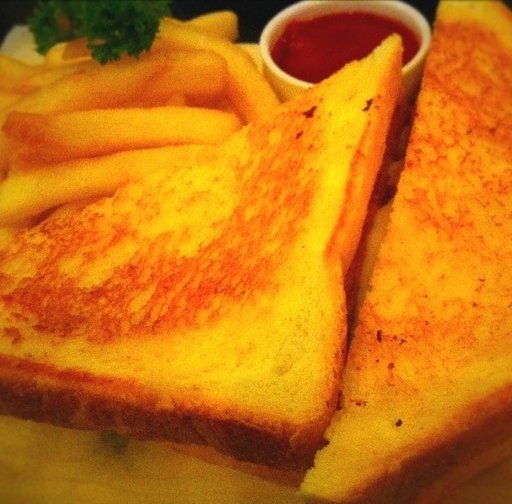

In [4]:
# Extract a specific image
dataset['image'][0]  # This is a Pillow Image instance

In [5]:
# Iterate over the images
for image in dataset['image']:
    # Here we can operate on them
    # For example, let's cast them to numpy arrays
    img = np.array(image)

    # Note that not all images have the same shape
    print(f"Image shape: {img.shape}")

Image shape: (504, 512, 3)
Image shape: (384, 512, 3)
Image shape: (512, 512, 3)
Image shape: (512, 512, 3)
Image shape: (384, 512, 3)


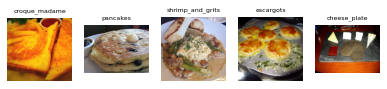

In [6]:
# Iterate over images and labels
fig, sub = plt.subplots(1, 5, dpi=75)

for i, row in enumerate(dataset):
    img = row['image']

    # Label here is typically an index
    label_idx = row['label']

    # To get the corresponding label
    label = dataset.features['label'].int2str(label_idx)

    sub[i].imshow(img)
    sub[i].set_title(label, fontsize=6)
    sub[i].axis("off")

In [7]:
# Applying a preprocessing function
# (for example to resize all images to the same size)
from transformers import AutoImageProcessor

# Initialize image processor
processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224")

def preprocess_function(examples):
    # Process images
    images = [image.convert("RGB") for image in examples["image"]]
    
    # Apply processor (resize, normalize, etc.)
    inputs = processor(images, return_tensors="pt")
        
    # Add processed images to examples
    examples["pixel_values"] = inputs["pixel_values"]
    
    return examples

# Apply preprocessing. This adds a new column called
# pixel_values
ds = dataset.map(preprocess_function, batched=True)

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

In [8]:
# Let's look at what the processor actually do
processor

ViTImageProcessor {
  "do_convert_rgb": null,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [9]:
# Now our images have been preprocessed into
# resized and normalized tensors
np.array(ds['pixel_values'][0]).shape

(3, 224, 224)

In [10]:
# We can also define our own processing
def preprocess_function(examples):
    # Process images
    images = []
    
    for image in examples['image']:

        # Apply some preprocessing to the image
        image = (
            image
            .convert("RGB")
            .rotate(10)
            # Gaussian blur
            .filter(ImageFilter.GaussianBlur(5))
        )

        # Be careful that some Pillow methods return None
        # and instead operate in place, like
        image.thumbnail((224, 224))

        images.append(image)
        
    # Add processed images to examples
    examples["preprocessed_images"] = images
    
    return examples

# Apply preprocessing. This adds a new column called
# pixel_values
ds_custom = dataset.map(preprocess_function, batched=True)

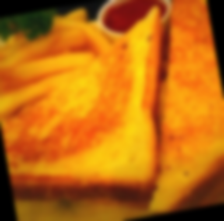

In [11]:
ds_custom['preprocessed_images'][0]

## Pixels and Channels

Sample image shape: (504, 512, 3)
Sample image class: 28 (croque_madame)
Total pixels per image: 774,144
RGB channels: 3 channels
RGB memory: 774,144 bytes
Grayscale memory: 258,048 bytes
Memory reduction: 66.7%


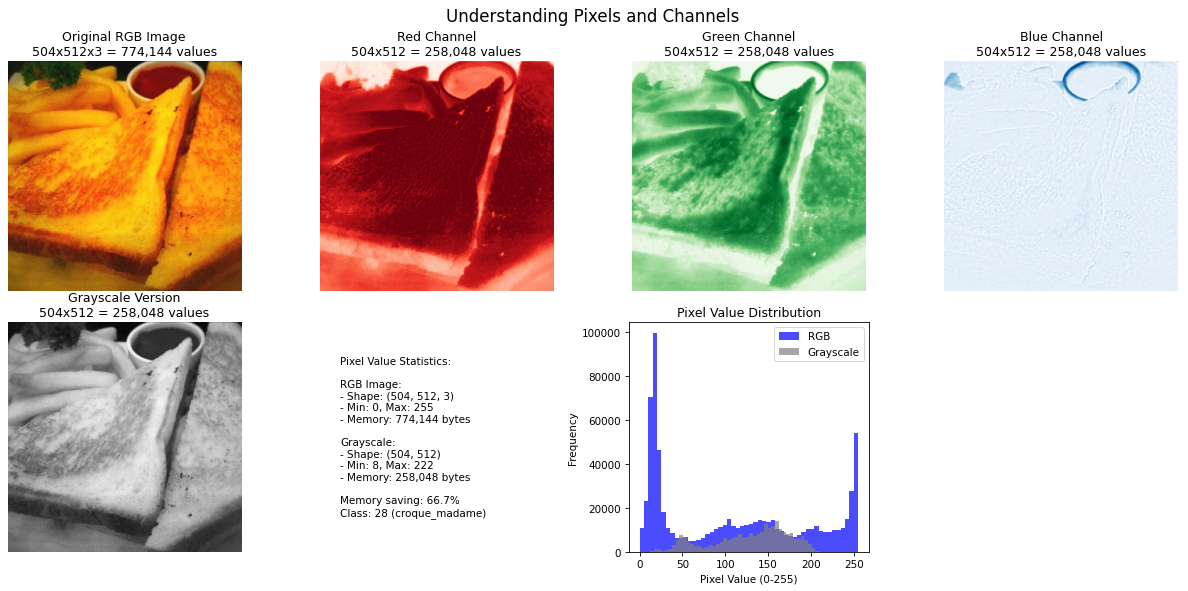

In [12]:
# Get sample image and basic info
sample_image = dataset[0]['image']  # PIL Image
sample_array = np.array(sample_image)
class_label = dataset[0]['label']
class_name = dataset.features['label'].int2str(class_label)

print(f"Sample image shape: {sample_array.shape}")
print(f"Sample image class: {class_label} ({class_name})")
print(f"Total pixels per image: {sample_array.size:,}")

# Convert RGB to grayscale
grayscale = cv2.cvtColor(sample_array, cv2.COLOR_RGB2GRAY)

# Key insight: Memory and computational differences
print(f"RGB channels: {sample_array.shape[2]} channels")
print(f"RGB memory: {sample_array.nbytes:,} bytes")
print(f"Grayscale memory: {grayscale.nbytes:,} bytes")
print(f"Memory reduction: {((1 - grayscale.nbytes/sample_array.nbytes)*100):.1f}%")

# Show visual comparison
plot_pixels_and_channels(sample_array, grayscale, f"{class_label} ({class_name})")


## Color spaces

Color Space Characteristics:
RGB - Standard display format: (504, 512, 3)
HSV - Separates color from brightness: (504, 512, 3)
LAB - Perceptually uniform: (504, 512, 3)
YUV - Separates luminance from chrominance: (504, 512, 3)
✓ All color spaces maintain same dimensions but different meanings


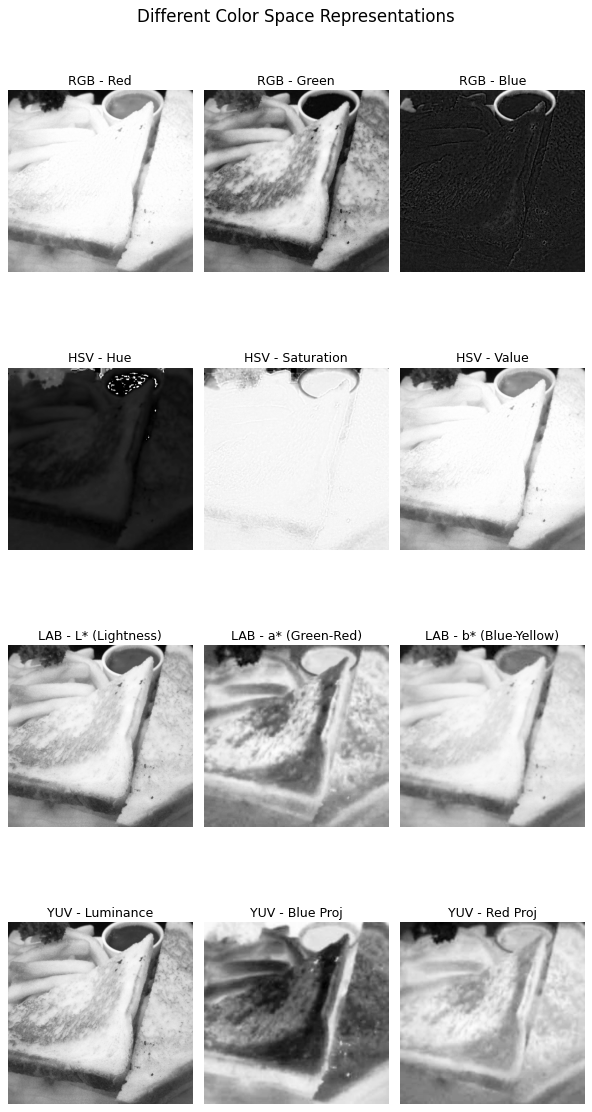

In [13]:

# Convert to different color spaces using OpenCV
rgb_image = sample_array
hsv_image = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2HSV)
lab_image = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2LAB)
yuv_image = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2YUV)

# Print characteristics of each color space
print("Color Space Characteristics:")
print(f"RGB - Standard display format: {rgb_image.shape}")
print(f"HSV - Separates color from brightness: {hsv_image.shape}")
print(f"LAB - Perceptually uniform: {lab_image.shape}")
print(f"YUV - Separates luminance from chrominance: {yuv_image.shape}")

# All still use 3 channels but represent different information
assert hsv_image.shape == lab_image.shape == yuv_image.shape == rgb_image.shape
print("✓ All color spaces maintain same dimensions but different meanings")

# Show visual comparison
plot_color_spaces(rgb_image, hsv_image, lab_image, yuv_image)


## Image formats

Compression Results:
Original (uncompressed): 322,752 bytes
PNG (lossless): 185,114 bytes (57.4% of original)
JPEG high quality: 44,598 bytes (13.8% of original)
JPEG low quality: 10,692 bytes (3.3% of original)


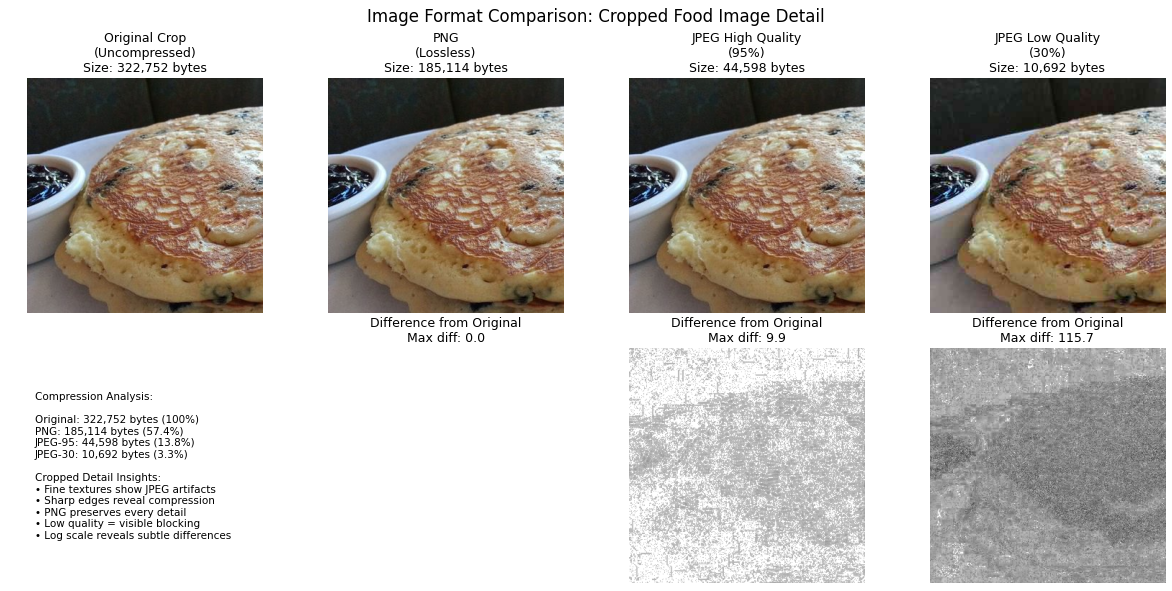

In [14]:
# Focus on a section of the image
test_image = np.array(dataset['image'][1])[:328, :328, ...]
test_class = f"{class_label} ({class_name})"

def get_image_size_and_quality(image_array, format_type, quality=None):
    """Save image in different formats and return size + reconstructed image"""
    pil_image = Image.fromarray(image_array)
    buffer = io.BytesIO()
    
    if format_type == 'PNG':
        pil_image.save(buffer, format='PNG')
    elif format_type == 'JPEG':
        pil_image.save(buffer, format='JPEG', quality=quality)
    
    size = buffer.tell()
    buffer.seek(0)
    reconstructed = Image.open(buffer)
    reconstructed_array = np.array(reconstructed.convert('RGB'))
    
    return size, reconstructed_array

# Test different compression methods
original_size = test_image.nbytes
png_size, png_reconstructed = get_image_size_and_quality(test_image, 'PNG')
jpeg_high_size, jpeg_high_reconstructed = get_image_size_and_quality(test_image, 'JPEG', quality=95)
jpeg_low_size, jpeg_low_reconstructed = get_image_size_and_quality(test_image, 'JPEG', quality=30)

sizes = [original_size, png_size, jpeg_high_size, jpeg_low_size]

print("Compression Results:")
print(f"Original (uncompressed): {original_size:,} bytes")
print(f"PNG (lossless): {png_size:,} bytes ({png_size/original_size*100:.1f}% of original)")
print(f"JPEG high quality: {jpeg_high_size:,} bytes ({jpeg_high_size/original_size*100:.1f}% of original)")
print(f"JPEG low quality: {jpeg_low_size:,} bytes ({jpeg_low_size/original_size*100:.1f}% of original)")

plot_compression_comparison(test_image, png_reconstructed, jpeg_high_reconstructed, 
                            jpeg_low_reconstructed, sizes)
